## Part I: Different Shapes of the Yield Curve

In [1]:
# Importing the libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import pandas as pd

In [2]:
r = 0.05
gamma = 0.25
etha = 0.25 * 0.03
sigma = 0.02
T = 30
N = 100

In [3]:
def vasicek(seed=0):
    np.random.seed(seed)
    dt = T[-1] / N  # time step based on maximum T
    interest_rate = [r]
    for i in range(N - 1):
        dr = (etha - gamma * interest_rate[-1]) * dt + sigma * np.random.normal(0, 1) * np.sqrt(dt)
        interest_rate.append(interest_rate[-1] + dr)
    return np.array(interest_rate)

In [4]:
def B(t, T, gamma):
    rho = T - t
    return (1 - np.exp(-gamma * rho)) / gamma

In [5]:
def A(t, T, gamma, eta, sigma):
    rho = T - t
    return (B(t, T, gamma) - rho) * (eta * gamma - sigma**2 / 2) / gamma**2 - (sigma**2 * B(t, T, gamma)**2) / 4 * gamma

In [6]:
def B_drvt(t, T, gamma):    # dérivée partielle de B par rapport à gamma
    rho = T - t
    return (rho * np.exp(-gamma * rho) - B(t, T, gamma)) / gamma

In [7]:
def A_drvt(t, T, gamma, sigma, eta):    # dérivée partielle de B par rapport à gamma
    rho = T - t
    return (eta * (B_drvt(t, T, gamma) * gamma - B(t, T, gamma)) + rho * eta - sigma**2 / 2 * (B_drvt(t, T, gamma)
            - 2 * B(t, T, gamma) / gamma) - rho * sigma**2 / gamma - sigma**2 * B(t, T, gamma) / 4
            * (2 * gamma * B_drvt(t, T, gamma) - B(t, T, gamma))) / gamma**2

In [8]:
def Yield(t, T, gamma, eta, sigma, r_o):  # Yield Curve
    rho = T - t
    B = (1 - np.exp(-gamma * rho)) / gamma
    A = (B - rho) * (eta * gamma - sigma**2 / 2) / gamma**2 - (sigma**2 * B**2) / 4 * gamma
    return - (A - r_o * B) / T

In [9]:
# Plot the Yield Curve with different interest rates

In [10]:
def plotYield():
    plt.clf()
    t = 0
    Time = np.linspace(0.01, T, N)
    Y1 = np.zeros(N)
    Y2 = np.zeros(N)
    Y3 = np.zeros(N)
    r_o = [0.01, 0.027, 0.05]   # short rate, which is limit of the Yield Curve
    for i in range(N):
        Y1[i] = Yield(0, Time[i], gamma, etha, sigma, r_o[0])
        Y2[i] = Yield(0, Time[i], gamma, etha, sigma, r_o[1])
        Y3[i] = Yield(0, Time[i], gamma, etha, sigma, r_o[2])
        
    plt.plot(Time, Y1, label='Asymptotically upward sloping (r_o = 0.01)')
    plt.plot(Time, Y2, label='Slightly humped (r_o = 0.01)')
    plt.plot(Time, Y3, label='Inverted (r_o = 0.01)')
    plt.legend()
    plt.title('Yield Curves with different short rates')
    plt.xlabel('Time')
    plt.ylabel('Yield')
    plt.show()

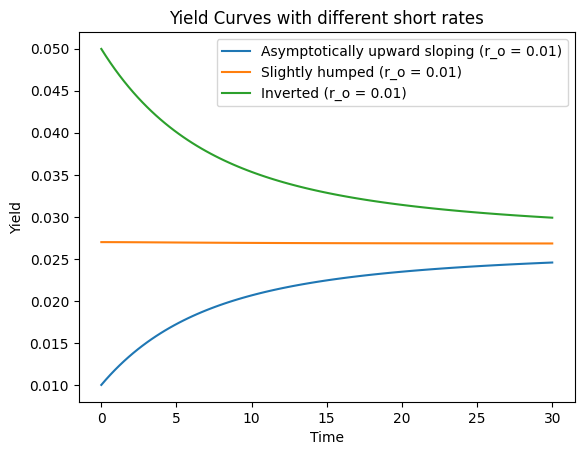

In [11]:
plotYield()

## Part II: Calibration to Yield Curve

### II.1) Calibration according the Yield Curve came from the market at the moment t = 0

In [12]:
def Levenberg():
    T = [3*i for i in range(1, 11)]
    Y_m = [0.035, 0.041, 0.0439, 0.046, 0.0484, 0.0494, 0.0507, 0.0514, 0.052, 0.0523]
    r_o = 0.023
    t = 0

    ''' Here Beta[0] = eta, 
            Beta[1] = sigma,
            Beta[2] = gamma
    '''
    Y_th = np.zeros(10)

    Jac = np.zeros((10, 3))
    Res = np.zeros(10)  # Y_th - Y_m
# -----------------------------------------Levenberg - Marquart  Parameters---------------------------------------------
    epsilon = 10 ** (-9)
    lamda = 0.01
    d = np.array([1, 1, 1])   # eta (1st position), sigma (2nd position), gamma (3rd position)
    beta = [0.1, 0.1, 0.1]  # Initialization of the 3 parameters
# ----------------------------------------Initialisation----------------------------------------------------------------
    y0 = Yield(0, T[0], beta[2], beta[0], beta[1], r_o)
    Y_th[0] = y0    # <>

    r0 = Y_m[0] - Y_th[0]
    Res[0] = r0
# ----------------------------------------------------------------------------------------------------------------------
    k = 0

    while np.linalg.norm(d, 2) > epsilon:
        for j in range(3):
            for p in range(10):

                if j == 0:
                    Jac[p][j] = (B(t, T[p], beta[2]) - (T[p] - t)) / (beta[2] * (T[p] - t))

                if j == 1:
                    Jac[p][j] = - 1 / ((T[p] - t) * beta[2]) * ((B(t, T[p], beta[2]) - (T[p] - t)) / (2 * beta[2])
                                                                + B(t, T[p], beta[2])**2 / 4)

                if j == 2:
                    Jac[p][j] = (A_drvt(t, T[p], beta[2], beta[1], beta[0]) - r_o * B_drvt(t, T[p], beta[2])) / (T[p] - t)

        for p in range(10):
            Y_th[p] = Yield(t, T[p], beta[2], beta[0], beta[1], r_o)
            Res[p] = Y_m[p] - Y_th[p]

        # Jac.transpose()   Transposed Jacobian Matrix
        # np.dot            For Matrix Multiplication
        # np.identity(N)    Diagonal Matrix of One
        # np.linalg.inv     Reverse Matrix
        
        for j in range(3):
            d = - np.dot(np.linalg.inv(np.dot(Jac.T, Jac) + lamda * np.identity(3)), np.dot(Jac.T, Res))
            beta[j] = beta[j] + d[j]
            
        k = k + 1
    return T, Y_th, Y_m, beta
    

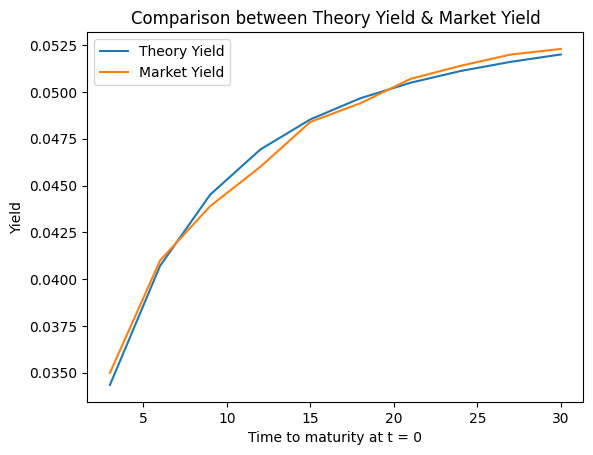

Optimal Eta      0.021661
Optimal Sigma    0.055011
Optimal Gamma    0.298770
dtype: float64


In [13]:
T = Levenberg()[0]
Y_th = Levenberg()[1]
Y_m = Levenberg()[2]
beta = Levenberg()[3]
plt.plot(T, Y_th, label = 'Theory Yield')
plt.plot(T, Y_m, label='Market Yield')
plt.legend()
plt.xlabel('Time to maturity at t = 0')
plt.ylabel('Yield')
plt.title('Comparison between Theory Yield & Market Yield')
plt.show()
df = pd.Series([beta[0], beta[1], beta[2]], index = ['Optimal Eta', 'Optimal Sigma', 'Optimal Gamma'])
print(df)

### II.2) Calibration according the Yield Curve came from the market at the moment t = 1

In [14]:
def LM():
    T = [3 * i for i in range(1, 11)]
    Y_m = [0.056, 0.064, 0.074, 0.081, 0.082, 0.09, 0.087, 0.092, 0.0895, 0.091]
    r_t = 0.04  # short rate with t = 1
    t = 1
    Y_th = np.zeros(10)
    Res = np.zeros(10)
    Jac = np.zeros((10, 3))
# -----------------------------------------  Levenberg - Marquart Parameters --------------------------------------------
    epsilon = 10 ** (-9)
    lamda = 0.01
    d = np.array([1, 1, 1])  # eta (1st position), sigma (2nd position), gamma (3rd position)
    beta = [0.1, 0.1, 0.1]  # Initialization of the 3 parameters
# ----------------------------------------Initialization----------------------------------------------------------------
    y0 = Yield(0, T[0], beta[2], beta[0], beta[1], r_t)
    Y_th[0] = y0  # <>

    r0 = Y_m[0] - Y_th[0]
    Res[0] = r0
# ----------------------------------------------------------------------------------------------------------------------
    while np.linalg.norm(d, 2) > epsilon:
        for j in range(3):
            for p in range(10):
        
                if j == 0:
                    Jac[p][j] = (B(t, T[p], beta[2]) - (T[p] - t)) / (beta[2] * (T[p] - t))
        
                if j == 1:
                    Jac[p][j] = - 1 / ((T[p] - t) * beta[2]) * ((B(t, T[p], beta[2]) - (T[p] - t)) / (2 * beta[2])
                                                                + B(t, T[p], beta[2]) ** 2 / 4)
        
                if j == 2:
                    Jac[p][j] = (A_drvt(t, T[p], beta[2], beta[1], beta[0]) - r_t * B_drvt(t, T[p], beta[2])) / (
                                T[p] - t)
        
        for p in range(10):
            Y_th[p] = Yield(t, T[p], beta[2], beta[0], beta[1], r_t)
            Res[p] = Y_m[p] - Y_th[p]
        
        for j in range(3):
            d = - np.dot(np.linalg.inv(np.dot(Jac.T, Jac) + lamda * np.identity(3)), np.dot(Jac.T, Res))
            beta[j] = beta[j] + d[j]
            
    return T, Y_th, Y_m, beta

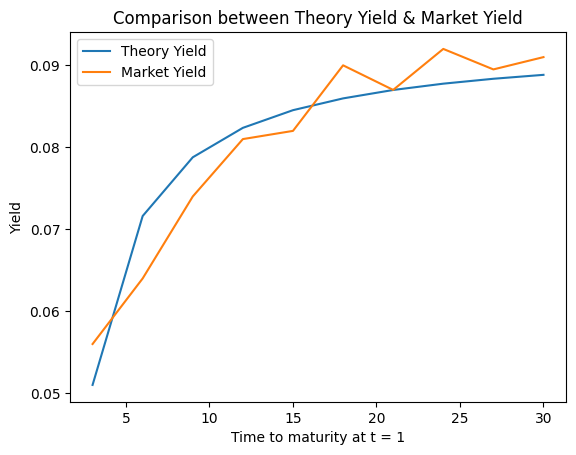

Optimal Eta      0.127099
Optimal Sigma    0.260809
Optimal Gamma    0.998966
dtype: float64


In [15]:
T = LM()[0]
Y_th = LM()[1]
Y_m = LM()[2]
beta = LM()[3]
plt.plot(T, Y_th, label='Theory Yield')
plt.plot(T, Y_m, label='Market Yield')
plt.legend()
plt.xlabel('Time to maturity at t = 1')
plt.ylabel('Yield')
plt.title('Comparison between Theory Yield & Market Yield')
plt.show()
df = pd.Series([beta[0], beta[1], beta[2]], index = ['Optimal Eta', 'Optimal Sigma', 'Optimal Gamma'])
print(df)

### Part III: Calibration to Historical Rates

In [41]:
def initialize_simulation(T=5, N=1000, eta=0.6, sigma=0.08, gamma=4, r0=0.023):
    delta_t = T / N
    t = np.linspace(0, T, N + 1)
    r = [r0]
    
    for i in range(N):
        r.append(r[-1] * np.exp(-gamma * delta_t) +
                 eta / gamma * (1 - np.exp(-gamma * delta_t)) +
                 sigma * np.sqrt((1 - np.exp(-2 * gamma * delta_t)) / (2 * gamma)) * np.random.randn())
    return t, r

In [ ]:
def plot_time_series(t, r):
    plt.plot(t, r)
    plt.xlabel('Time')
    plt.ylabel('Interest Rate')
    plt.title('Market Rates using the theoretical formula')
    plt.show()

In [ ]:
def plot_scatter_series(r, N):
    x = r[:N]
    y = r[1:]
    plt.scatter(x, y)
    plt.xlabel('r_i')
    plt.ylabel('r_(i+1)')
    plt.title('Market Dates r_(i+1) related to r_i')
    plt.show()
    return x, y

In [ ]:
def levenberg_marquardt_optimization(x, y, epsilon=1e-9, lamda=0.01):
    N = len(x)
    beta = [0.1, 0.1]
    d = [1, 1]
    
    Jac = np.zeros((N, 2))
    Res = np.zeros(N)
    line = np.zeros(N)
    
    while np.linalg.norm(d) > epsilon:
        for j in range(2):
            for p in range(N):
                Jac[p][j] = -x[p] if j == 0 else -1
        
        for p in range(N):
            line[p] = beta[0] * x[p] + beta[1]
            Res[p] = y[p] - line[p]
        
        d = -np.dot(np.linalg.inv(np.dot(Jac.T, Jac) + lamda * np.identity(2)), np.dot(Jac.T, Res))
        beta = [beta[j] + d[j] for j in range(2)]
    
    return beta, line

In [ ]:
def plot_optimization_result(x, y, line, beta):
    plt.scatter(x, y, label='Time series Market Rates r_(i+1) related to r_i')
    plt.plot(x, line, c='r', label=f'Linear regression (Slope: {beta[0]:.4f}, Intercept: {beta[1]:.4f})')
    plt.title('Linear Optimization using Levenberg-Marquardt')
    plt.legend()
    plt.show()

In [43]:
def HistDates():
    # Initialization and Simulation
    T, N = 5, 1000
    t, r = initialize_simulation(T, N)
    
    # Plot time series
    plot_time_series(t, r)
    
    # Plot scatter plot and prepare data for optimization
    x, y = plot_scatter_series(r, N)
    
    # Perform Levenberg-Marquardt Optimization
    beta, line = levenberg_marquardt_optimization(x, y)
    
    # Display results and plot optimization
    df = pd.Series([beta[0], beta[0]], index = ['Optimized Slope', 'Optimized Intercept'])
    print(df)
    plot_optimization_result(x, y, line, beta)

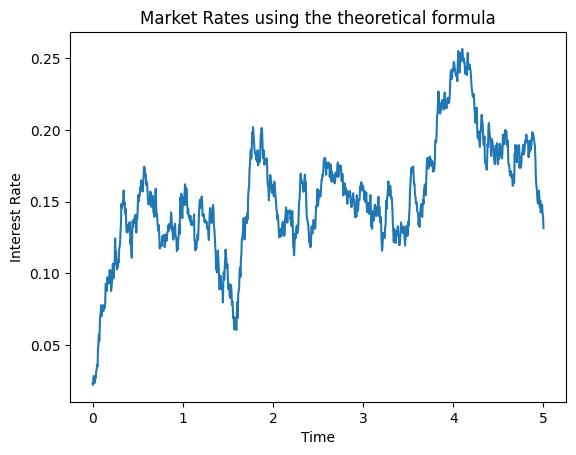

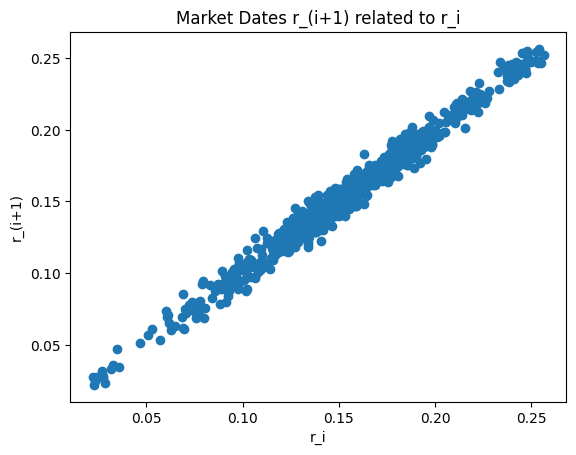

Optimized Slope        0.984782
Optimized Intercept    0.984782
dtype: float64


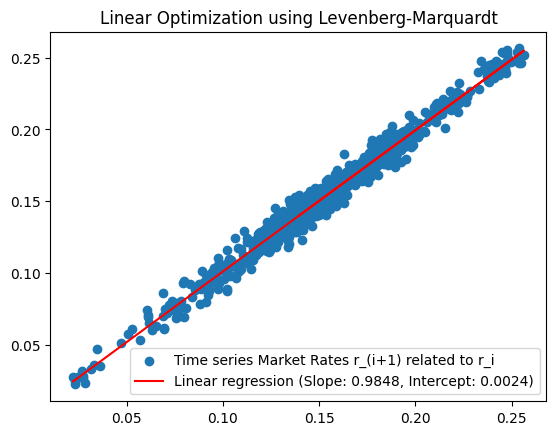

In [44]:
HistDates()